In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score 
from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA

df=pd.read_excel(r"D:\Data Science\Assignments\Pending\Clustering\EastWestAirlines.xlsx",sheet_name=1)
df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


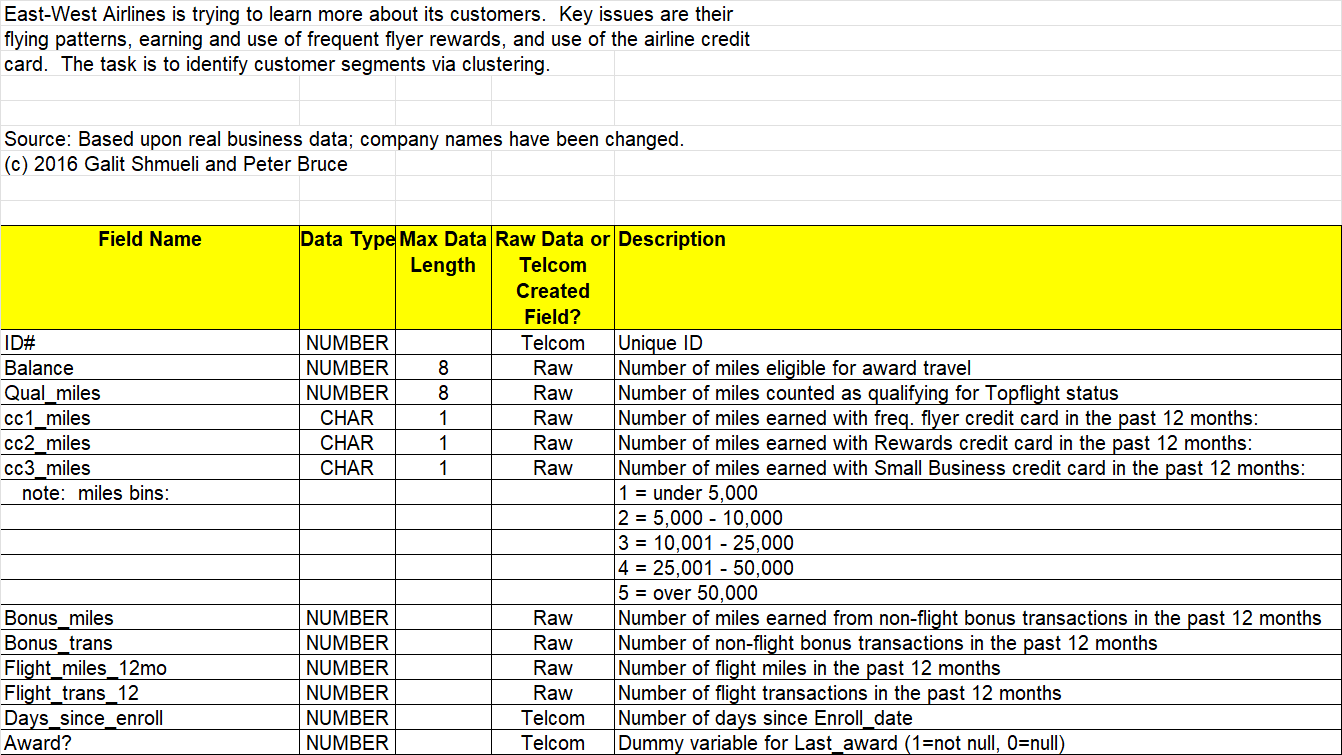

The goal was to segment 4,000 passengers based on their flight and credit card behavior to optimize the airline’s loyalty program.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID#                3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award?             3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


array([[<Axes: title={'center': 'ID#'}>,
        <Axes: title={'center': 'Balance'}>,
        <Axes: title={'center': 'Qual_miles'}>,
        <Axes: title={'center': 'cc1_miles'}>],
       [<Axes: title={'center': 'cc2_miles'}>,
        <Axes: title={'center': 'cc3_miles'}>,
        <Axes: title={'center': 'Bonus_miles'}>,
        <Axes: title={'center': 'Bonus_trans'}>],
       [<Axes: title={'center': 'Flight_miles_12mo'}>,
        <Axes: title={'center': 'Flight_trans_12'}>,
        <Axes: title={'center': 'Days_since_enroll'}>,
        <Axes: title={'center': 'Award?'}>]], dtype=object)

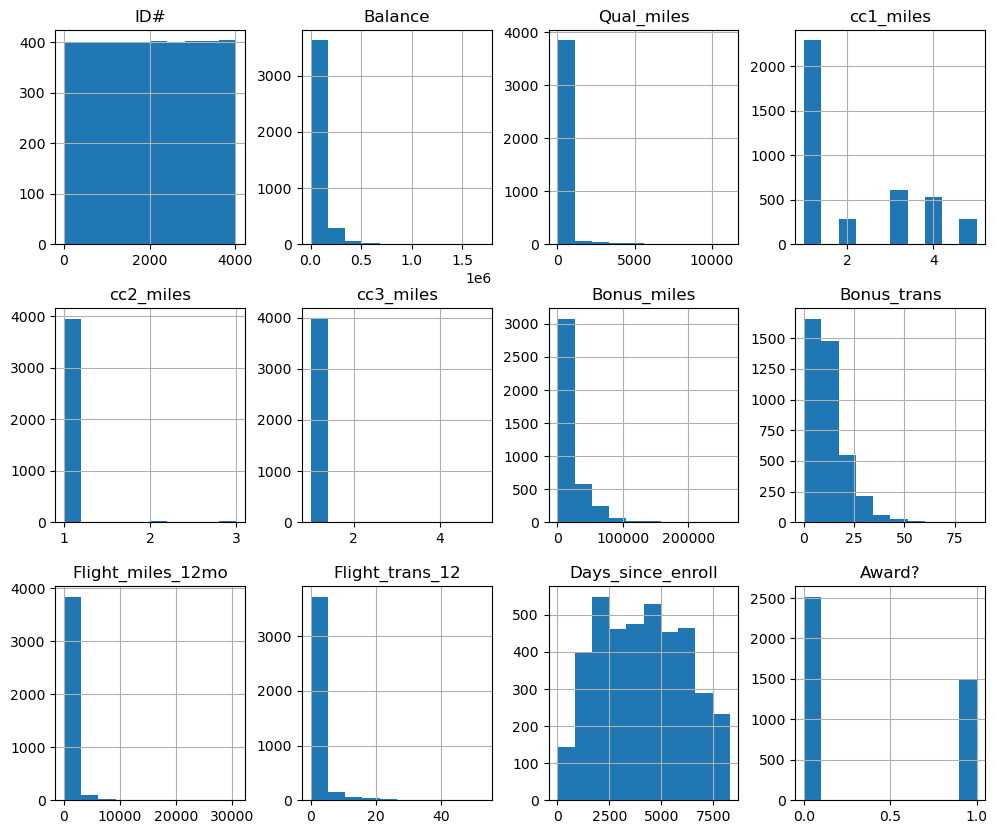

In [5]:
df.hist(layout=(3,4),figsize=(12,10))

In [6]:
df.isnull().sum()

ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64

In [7]:
df.nunique()

ID#                  3999
Balance              3904
Qual_miles            164
cc1_miles               5
cc2_miles               3
cc3_miles               5
Bonus_miles          2734
Bonus_trans            57
Flight_miles_12mo     343
Flight_trans_12        35
Days_since_enroll    2820
Award?                  2
dtype: int64

Column Selection: Unique identifiers like ID# were dropped to focus purely on behavioral data.

In [9]:
# ID# column is unique id so, dropping it from the features.

df=df.drop("ID#",axis=1)

In [10]:
df.describe()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


In [11]:
df.corr()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
Balance,1.000000,0.108722,0.338344,-0.008804,0.035243,0.403487,0.324935,0.217551,0.255700,0.263129,0.178494
Qual_miles,0.108722,1.000000,0.007931,-0.013923,-0.007779,0.031021,0.050725,0.126774,0.144004,0.017312,0.095256
cc1_miles,0.338344,0.007931,1.000000,-0.068223,0.060555,0.825200,0.608943,0.037370,0.041333,0.230849,0.335457
cc2_miles,-0.008804,-0.013923,-0.068223,1.000000,-0.006166,-0.003969,0.064399,0.010598,0.028284,-0.005807,0.005332
cc3_miles,0.035243,-0.007779,0.060555,-0.006166,1.000000,0.204134,0.097313,-0.001777,-0.001117,0.010832,0.023484
Bonus_miles,0.403487,0.031021,0.825200,-0.003969,0.204134,1.000000,0.603180,0.183536,0.185261,0.210397,0.373506
Bonus_trans,0.324935,0.050725,0.608943,0.064399,0.097313,0.603180,1.000000,0.377216,0.432364,0.161262,0.333893
Flight_miles_12mo,0.217551,0.126774,0.037370,0.010598,-0.001777,0.183536,0.377216,1.000000,0.869193,0.037271,0.217715
Flight_trans_12,0.255700,0.144004,0.041333,0.028284,-0.001117,0.185261,0.432364,0.869193,1.000000,0.059260,0.247909
Days_since_enroll,0.263129,0.017312,0.230849,-0.005807,0.010832,0.210397,0.161262,0.037271,0.059260,1.000000,0.188121


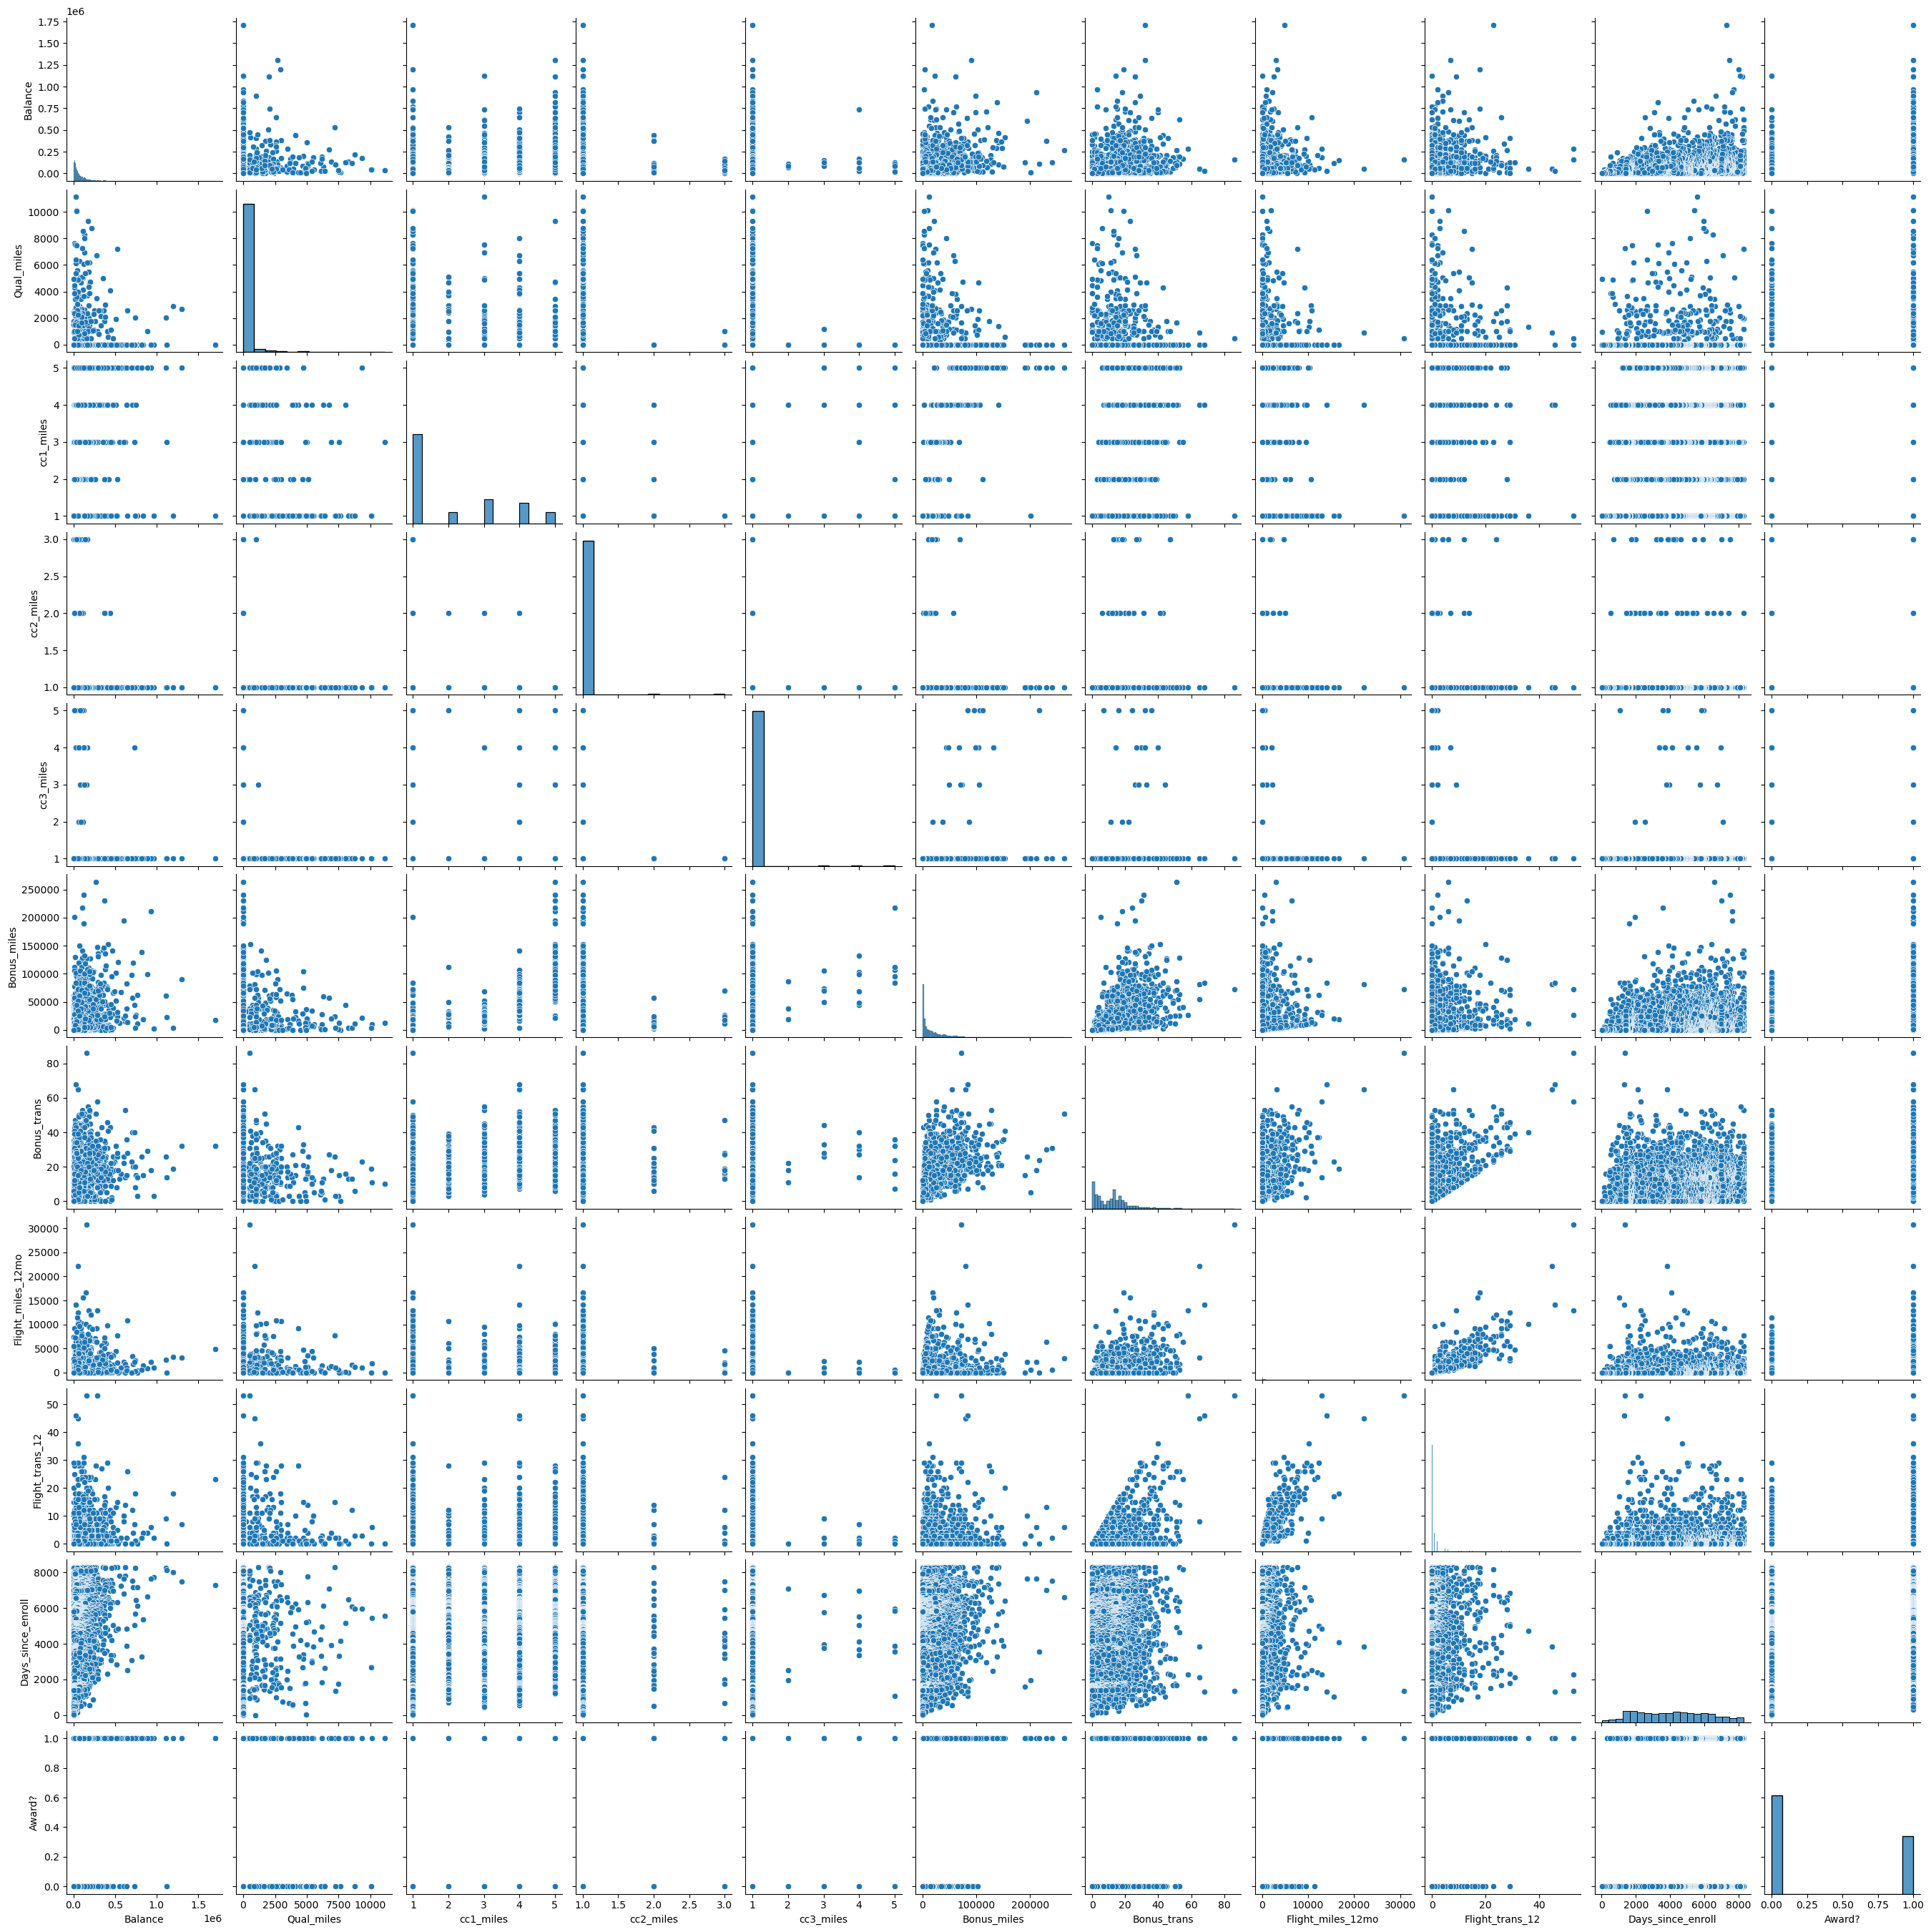

In [12]:
sns.pairplot(df)

Clustering relies on Euclidean Distance, and if one feature has a larger range, it will dominate the distance calculation. So, we will use StandardScaler to standarize each columns

In [14]:
scale=StandardScaler()
scaled_data=scale.fit_transform(df)

In [15]:
scaled_data

array([[-4.51140783e-01, -1.86298687e-01, -7.69578406e-01, ...,
        -3.62167870e-01,  1.39545434e+00, -7.66919299e-01],
       [-5.39456874e-01, -1.86298687e-01, -7.69578406e-01, ...,
        -3.62167870e-01,  1.37995704e+00, -7.66919299e-01],
       [-3.20031232e-01, -1.86298687e-01, -7.69578406e-01, ...,
        -3.62167870e-01,  1.41192021e+00, -7.66919299e-01],
       ...,
       [-4.29480975e-05, -1.86298687e-01,  6.83121167e-01, ...,
        -3.62167870e-01, -1.31560393e+00,  1.30391816e+00],
       [-1.85606976e-01, -1.86298687e-01, -7.69578406e-01, ...,
        -9.85033311e-02, -1.31608822e+00, -7.66919299e-01],
       [-7.00507951e-01, -1.86298687e-01, -7.69578406e-01, ...,
        -3.62167870e-01, -1.31754109e+00, -7.66919299e-01]])

In [16]:
# 1. Initialize PCA (Principle Component Analysis) to reduce data to 2 components (X and Y)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# 2. Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])


### Now I am going to use Hierarchical Clustering (The "Family Tree")
#### This is usually the first algorithm to run because it helps visualize the structure of the data through a Dendrogram.
#### Key Concept: It builds clusters by either starting with one big group and splitting it (Divisive) or starting with every point as a cluster and merging them (Agglomerative).


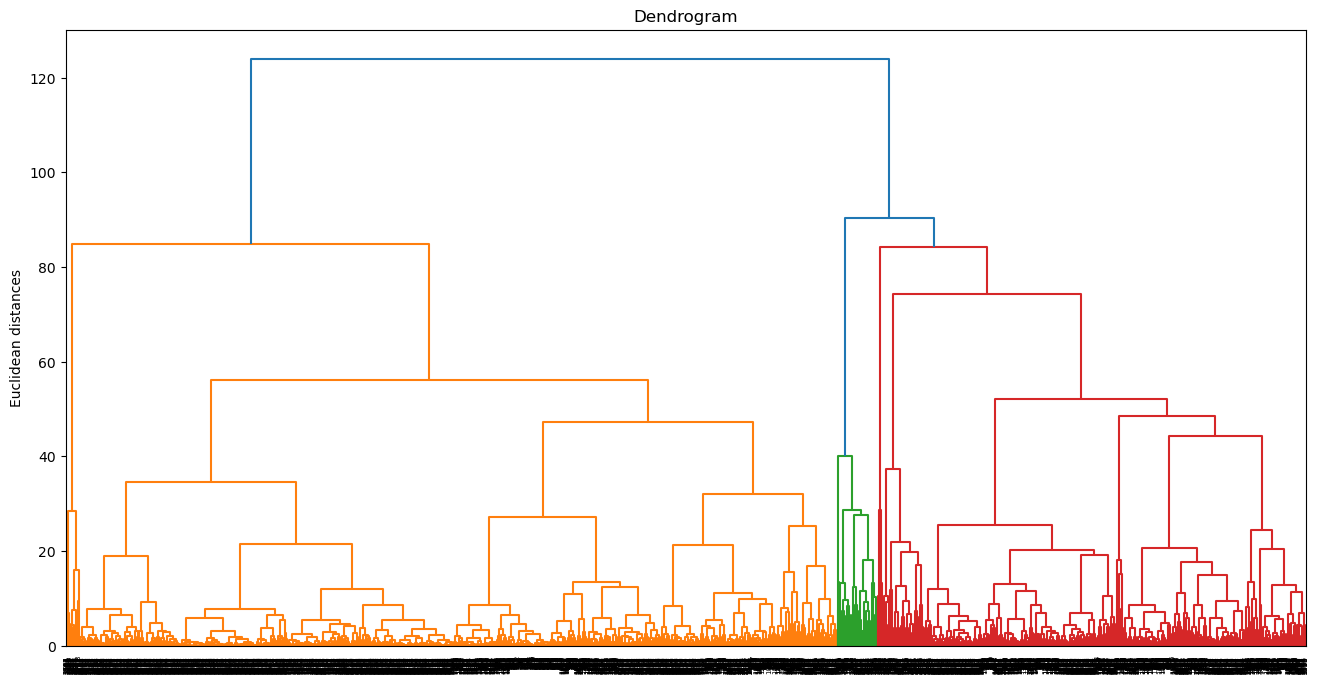

In [18]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# Create Dendrogram
plt.figure(1, figsize = (16 ,8))
dendrogram = sch.dendrogram(sch.linkage(scaled_data, method='ward'))
plt.title("Dendrogram")
plt.ylabel('Euclidean distances')
plt.show()

# Apply the model
hc = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
y_hc = hc.fit_predict(scaled_data)

In [19]:
for i in range (2,11):
    hc=AgglomerativeClustering(n_clusters=i,metric='euclidean',linkage='ward')
    y_hc=hc.fit_predict(scaled_data)
    hc_score = silhouette_score(scaled_data, y_hc)
    print(f'Hierarchical Clustering Silhouette Score for {i} clusters: {hc_score:.4f}')

Hierarchical Clustering Silhouette Score for 2 clusters: 0.2893
Hierarchical Clustering Silhouette Score for 3 clusters: 0.2940
Hierarchical Clustering Silhouette Score for 4 clusters: 0.3081
Hierarchical Clustering Silhouette Score for 5 clusters: 0.3099
Hierarchical Clustering Silhouette Score for 6 clusters: 0.3193
Hierarchical Clustering Silhouette Score for 7 clusters: 0.1897
Hierarchical Clustering Silhouette Score for 8 clusters: 0.1891
Hierarchical Clustering Silhouette Score for 9 clusters: 0.1952
Hierarchical Clustering Silhouette Score for 10 clusters: 0.2012


In [29]:
# Creating hierarchical clustering model and fitting it with 5 clusters 
hc_5=AgglomerativeClustering(n_clusters=5,metric='euclidean',linkage='ward')

y_hc_5=hc_5.fit_predict(scaled_data)
# Adding the cluster labels to the original dataframe
df['Cluster_ID_5'] = y_hc_5

# See the average values for each cluster
cluster_profile = df.groupby('Cluster_ID_5').mean()
analysis_5 = cluster_profile.T
print(analysis_5)

# Optional: Style it to highlight the highest values in each row
analysis_5.style.highlight_max(axis=1, color='lightgreen')

Cluster_ID_5                   0             1              2             3  \
Balance            116134.226872  46329.336877  134880.892308  68876.581395   
Qual_miles            367.779736      9.028618     393.323077     23.255814   
cc1_miles               3.500000      1.244072       2.430769      1.139535   
cc2_miles               1.000000      1.000000       1.000000      2.348837   
cc3_miles               1.000000      1.000000       1.000000      1.000000   
Bonus_miles         36501.331865   4868.112428   36582.169231  14689.837209   
Bonus_trans            17.958884      6.907604      29.338462     17.534884   
Flight_miles_12mo     376.402349    214.812756    5915.523077    582.627907   
Flight_trans_12         1.147577      0.673753      16.638462      2.209302   
Days_since_enroll    4699.638767   3769.337694    4599.607692   3968.930233   
Award?                  0.665198      0.184383       0.753846      0.395349   

Cluster_ID_5                   4  
Balance         

Cluster_ID_5,0,1,2,3,4
Balance,116134.226872,46329.336877,134880.892308,68876.581395,129951.388889
Qual_miles,367.779736,9.028618,393.323077,23.255814,65.666667
cc1_miles,3.500000,1.244072,2.430769,1.139535,3.388889
cc2_miles,1.000000,1.000000,1.000000,2.348837,1.000000
cc3_miles,1.000000,1.000000,1.000000,1.000000,3.722222
Bonus_miles,36501.331865,4868.112428,36582.169231,14689.837209,86259.888889
Bonus_trans,17.958884,6.907604,29.338462,17.534884,26.222222
Flight_miles_12mo,376.402349,214.812756,5915.523077,582.627907,422.222222
Flight_trans_12,1.147577,0.673753,16.638462,2.209302,1.333333
Days_since_enroll,4699.638767,3769.337694,4599.607692,3968.930233,4488.777778


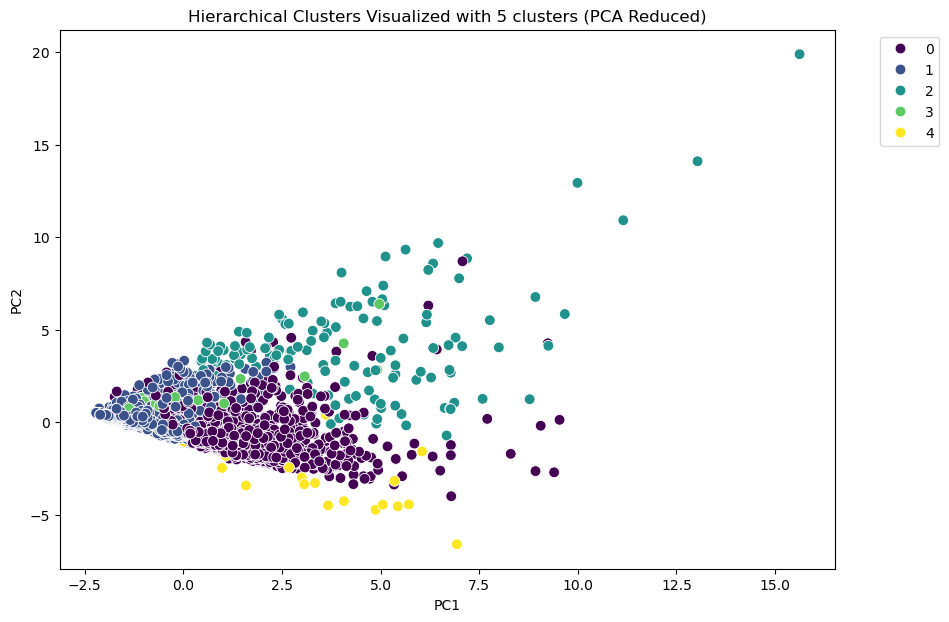

In [31]:
pca_df['hc_cluster_5']=y_hc_5
plt.figure(figsize=(10,7))
sns.scatterplot(data=pca_df,x='PC1',y='PC2',hue='hc_cluster_5',palette='viridis',s=60)
plt.title('Hierarchical Clusters Visualized with 5 clusters (PCA Reduced)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [33]:
# 2nd model for Hierachical clusterring using n=6

hc6 = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')
y_hc6 = hc6.fit_predict(scaled_data)
df['Cluster_ID_6']=y_hc6

cluster_profile_6 = df.groupby('Cluster_ID_6').mean()
analysis_6 = cluster_profile_6.T
print(analysis_6)

analysis_6.style.highlight_max(axis=1, color='lightgreen')

Cluster_ID_6                  0              1              2             3  \
Balance            46329.336877  116758.363636  134880.892308  68876.581395   
Qual_miles             9.028618      37.024351     393.323077     23.255814   
cc1_miles              1.244072       3.672890       2.430769      1.139535   
cc2_miles              1.000000       1.000000       1.000000      2.348837   
cc3_miles              1.000000       1.000000       1.000000      1.000000   
Bonus_miles         4868.112428   38535.185065   36582.169231  14689.837209   
Bonus_trans            6.907604      18.683442      29.338462     17.534884   
Flight_miles_12mo    214.812756     339.391234    5915.523077    582.627907   
Flight_trans_12        0.673753       1.029221      16.638462      2.209302   
Days_since_enroll   3769.337694    4756.469968    4599.607692   3968.930233   
Award?                 0.184383       0.672078       0.753846      0.395349   
Cluster_ID_5           1.000000       0.000000      

Cluster_ID_6,0,1,2,3,4,5
Balance,46329.336877,116758.363636,134880.892308,68876.581395,129951.388889,110219.330769
Qual_miles,9.028618,37.024351,393.323077,23.255814,65.666667,3502.323077
cc1_miles,1.244072,3.672890,2.430769,1.139535,3.388889,1.861538
cc2_miles,1.000000,1.000000,1.000000,2.348837,1.000000,1.000000
cc3_miles,1.000000,1.000000,1.000000,1.000000,3.722222,1.000000
Bonus_miles,4868.112428,38535.185065,36582.169231,14689.837209,86259.888889,17226.661538
Bonus_trans,6.907604,18.683442,29.338462,17.534884,26.222222,11.092308
Flight_miles_12mo,214.812756,339.391234,5915.523077,582.627907,422.222222,727.153846
Flight_trans_12,0.673753,1.029221,16.638462,2.209302,1.333333,2.269231
Days_since_enroll,3769.337694,4756.469968,4599.607692,3968.930233,4488.777778,4161.053846


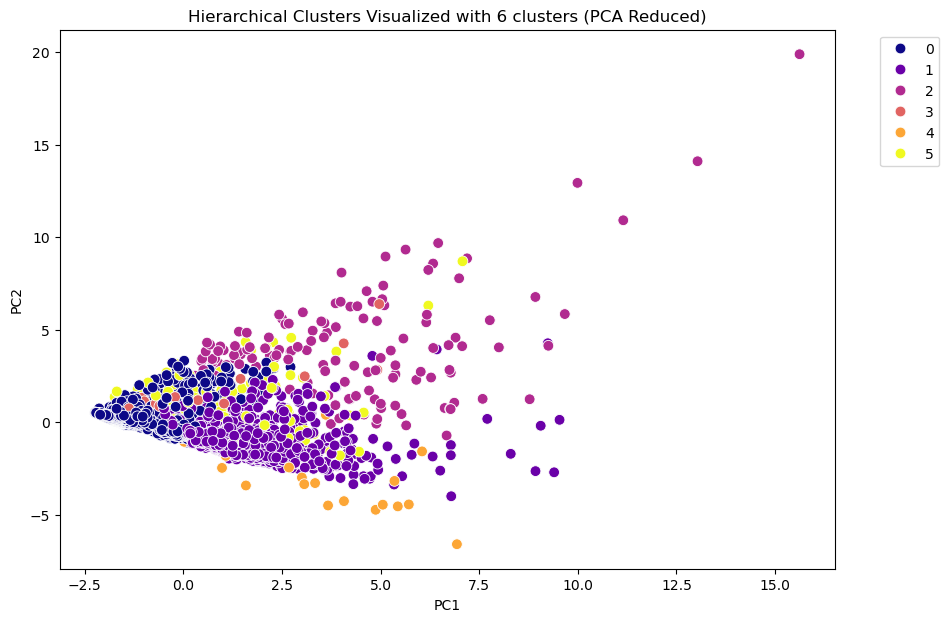

In [35]:
pca_df['hc_cluster_6']=y_hc6
plt.figure(figsize=(10,7))
sns.scatterplot(data=pca_df,x='PC1',y='PC2',hue='hc_cluster_6',palette='plasma',s=60)
plt.title('Hierarchical Clusters Visualized with 6 clusters (PCA Reduced)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

### K-Means
#### K-Means Clustering (The "Centroid" Search): This is the most popular algorithm. 
- It tries to group data points into $K$ clusters by minimizing the distance between points and their "Centroid" (center).
- The "Elbow Method": Since we have to tell K-Means how many clusters we want, we run a loop and plot the WCSS (Within-Cluster Sum of Squares).
- Where the graph "bends" like an elbow is our optimal $K$.

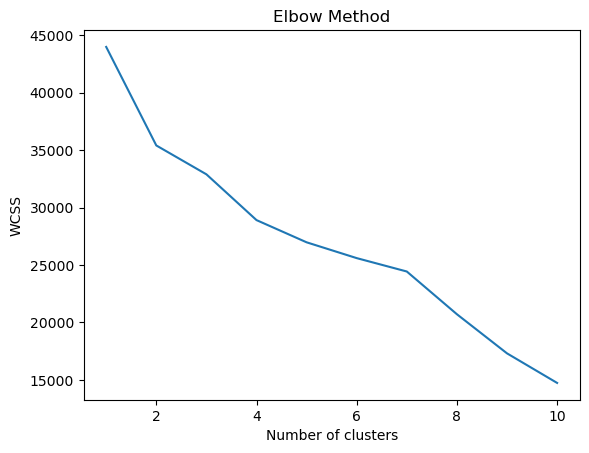

In [37]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

While Hierarchical clustering used a Dendrogram to show the relationship between passengers, K-Means uses the Elbow Method to optimize the compactness of the clusters.

For n_clusters = 2, Silhouette Score is 0.3254
For n_clusters = 3, Silhouette Score is 0.2674
For n_clusters = 4, Silhouette Score is 0.1907
For n_clusters = 5, Silhouette Score is 0.2005
For n_clusters = 6, Silhouette Score is 0.2110
For n_clusters = 7, Silhouette Score is 0.2219
For n_clusters = 8, Silhouette Score is 0.2307
For n_clusters = 9, Silhouette Score is 0.2424
For n_clusters = 10, Silhouette Score is 0.2606


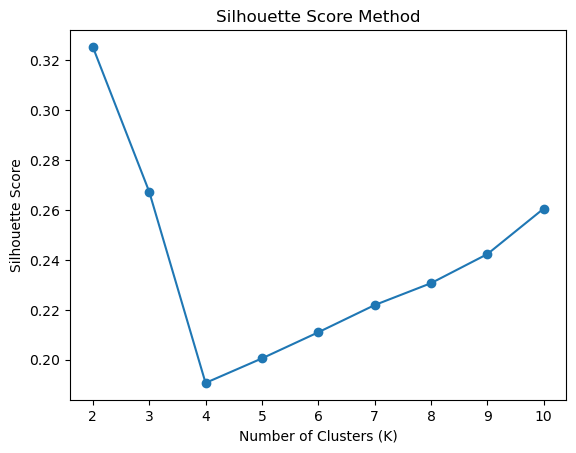

In [39]:
# Store scores
sil_scores = []

# We start from 2 clusters because silhouette score is not defined for 1 cluster
for k in range(2, 11):
    km = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = km.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    sil_scores.append(score)
    print(f'For n_clusters = {k}, Silhouette Score is {score:.4f}')

# Plotting the scores
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

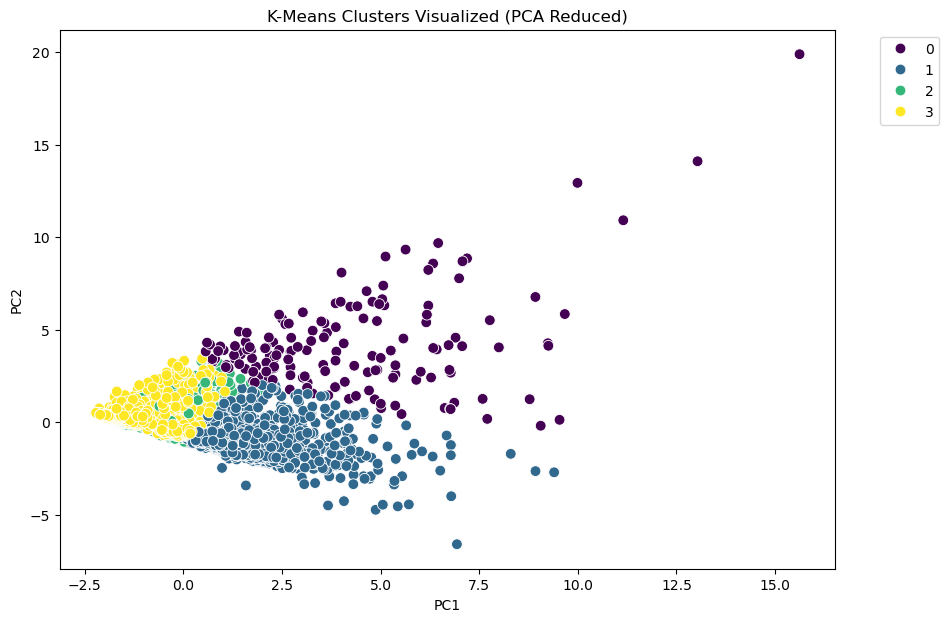

In [41]:
from sklearn.decomposition import PCA
import seaborn as sns


# Add the K-Means cluster labels (assuming you ran K-Means with k=4)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
pca_df['K_Cluster_4'] = kmeans.fit_predict(scaled_data)

# 4. Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='K_Cluster_4', data=pca_df, palette='viridis', s=60)
plt.title('K-Means Clusters Visualized (PCA Reduced)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

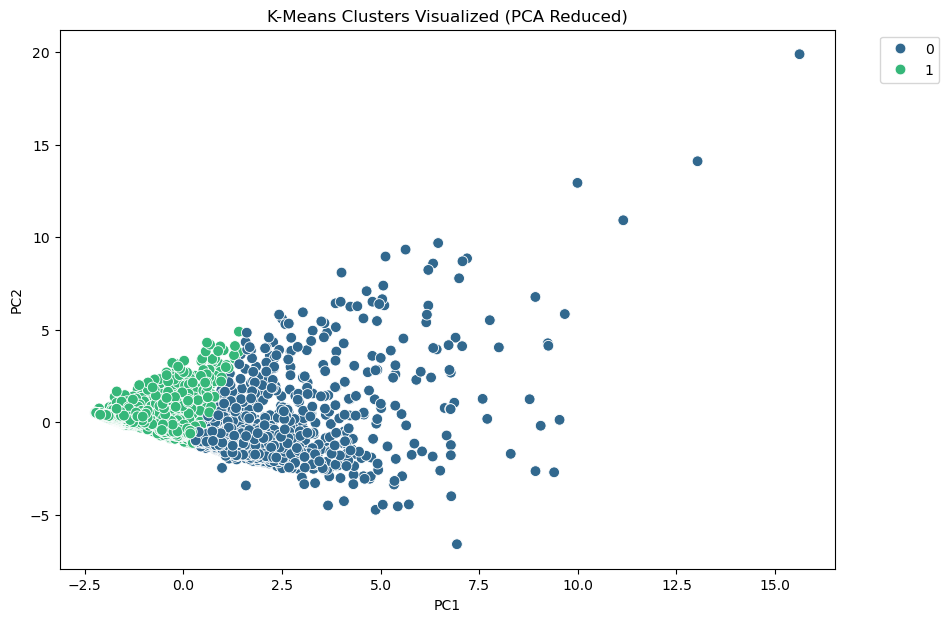

In [43]:
# Add the K-Means cluster labels (assuming you ran K-Means with k=2)
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
pca_df['K_Cluster_2'] = kmeans.fit_predict(scaled_data)

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='K_Cluster_2', data=pca_df, palette='viridis', s=60)
plt.title('K-Means Clusters Visualized (PCA Reduced)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

##### In our Airlines dataset, we have some passengers who are so unique (e.g., millions of miles or incredibly high transactions) that they don't fit into any "normal" group.

- K-Means will force them into the nearest cluster, which ruins the cluster's average.

- DBSCAN will label them as -1 (Noise/Outliers).

- DBSCAN requires two parameters: eps (radius) and min_samples (minimum neighbors).

The peak silhouette score is for 6 cluster in hierarchical clustering 0.3193

Whereas K-Means is having highest silhouette score at 2 cluster 0.32

In DBSCAN with min_samples=5 we are getting lowest Silhouette score -0.07

In [45]:
for e in [0.5, 1.0, 1.5, 2.0]:
    db = DBSCAN(eps=e, min_samples=5).fit(scaled_data)
    labels = db.labels_
    # Filter out noise for silhouette calculation
    if len(set(labels)) > 1:
        score = silhouette_score(scaled_data, labels)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"Eps: {e} | Score: {score:.3f} | Clusters: {n_clusters}")

Eps: 0.5 | Score: -0.078 | Clusters: 16
Eps: 1.0 | Score: 0.198 | Clusters: 6
Eps: 1.5 | Score: 0.254 | Clusters: 5
Eps: 2.0 | Score: 0.254 | Clusters: 6


In [46]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
clusters = dbscan.fit_predict(scaled_data)

# 2. Add to your dataframe
df['DBSCAN_Cluster'] = clusters

# 3. Check how many clusters were found
# Note: -1 is Noise
print(df['DBSCAN_Cluster'].value_counts())

DBSCAN_Cluster
 0    2411
 1    1250
-1     310
 2      15
 3       8
 4       5
Name: count, dtype: int64


In [49]:
silhouette_score(scaled_data, clusters)

0.253747538041624

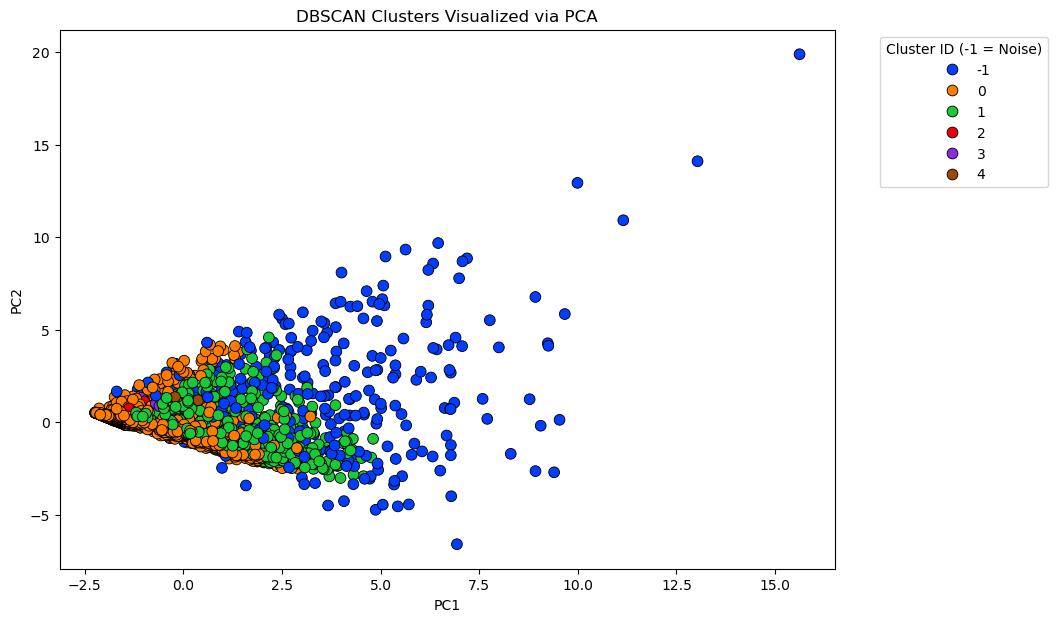

In [51]:
pca_df['DB_cluster']=clusters
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=pca_df, 
    x='PC1', 
    y='PC2', 
    hue='DB_cluster', 
    palette='bright', 
    s=60, 
    edgecolor='black'
)

plt.title('DBSCAN Clusters Visualized via PCA')
plt.legend(title='Cluster ID (-1 = Noise)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

While K-Means forced every passenger into a group, the DBSCAN scatterplot clearly identifies 'fringe' passengers (Cluster -1). These represent 12% of our data and are likely individuals with extreme mileage or highly irregular transaction patterns that would otherwise skew our K-Means centroids

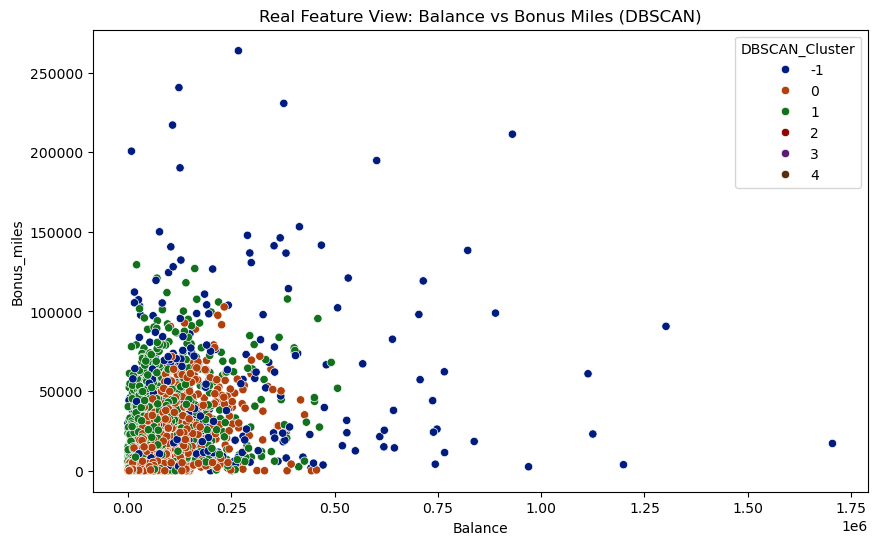

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, 
    x='Balance', 
    y='Bonus_miles', 
    hue='DBSCAN_Cluster', 
    palette='dark'
)
plt.title('Real Feature View: Balance vs Bonus Miles (DBSCAN)')
plt.show()

While K-Means had a peak Silhouette Score at $K=2$, We likely chose Hierarchical (K=6) or K-Means (K=5) for the final analysis.Justification: $K=2$ is too broad for business. $K=5$ or $K=6$ provides the "Granularity" needed to design specific rewards (e.g., a specific strategy for "New Frequent Flyers" vs. "Old Budget Travelers").Silhouette Score: our score of ~0.32 indicates that while there is some overlap, the clusters are mathematically significant.